# Speech Application

## Introduction

In this notebook, we will explore a practical application of AudioSigPy by conducting speech analysis and attempting to predict the speaker. We will focus on 
- using edge detection to detect speech,
- extracting spectral features from speech samples, and 
- using these features to classify the speaker

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import AudioSigPy as asp

import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix

asp.manage_directory("audio/examples/speech")

AudioSigPy package initialized
[WARNING] Manage Directory: The directory audio/examples/speech already exists and will not be deleted.


## Detecting Speech Segments

Here we will use edge detection to detect the segments of the audio where speech occurs. This process helps us isolate the parts of the audio that contain speech, filtering out silence or background noise. 

In [2]:
segments = []
for spkr, n in {"biden": 37, "trump": 36}.items():
    for i in range(n):
        wf = asp.Waveform(f"{spkr}-{i}")
        wf.read(f"audio/samples/speech/2024-pres-debate/{spkr}-{i}.wav")
        segments.append(wf)

In [3]:
# Demo function for edge detection
def edge_detection(signal):
    data = signal.get_signal_data()
    fs = signal.get_sample_rate()

    duration = 5
    sample_count = int(duration * fs)
    data = data[:sample_count]
    
    endpoints = asp.find_endpoints(
        signal=data, 
        sample_rate=fs,
        int_threshold=40,
        zcr_threshold=0.05
    )
    ts = np.linspace(0, duration, len(endpoints[0]))

    segments[0].plot_waveform(xlim=(0, 5), overlay=True)

    # Create a figure with 3 subplots, sharing the x-axis
    fig, axs = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

    # Plot each set of data with its own y-axis label
    axs[0].plot(ts, endpoints[0])
    axs[0].set_ylabel('Intensity (dB)')

    axs[1].plot(ts, endpoints[1])
    axs[1].set_ylabel('Zero Crossing Rate')

    axs[2].plot(ts, endpoints[2])
    axs[2].set_ylabel('Silence')

    # Set a common x-axis label
    axs[2].set_xlabel('Time (s)')

    # Add a super title for the entire figure
    fig.suptitle('Edge Detection of Biden Speech Sample')

    # Adjust the layout to prevent overlap and ensure a tight fit
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()


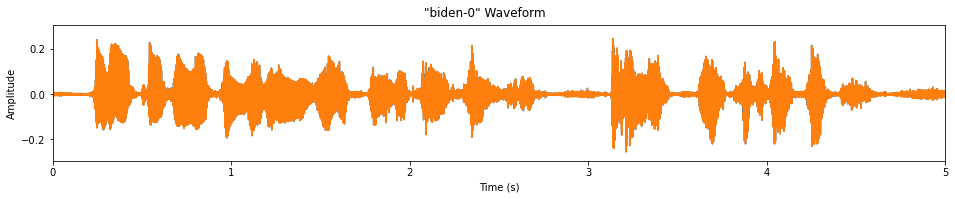

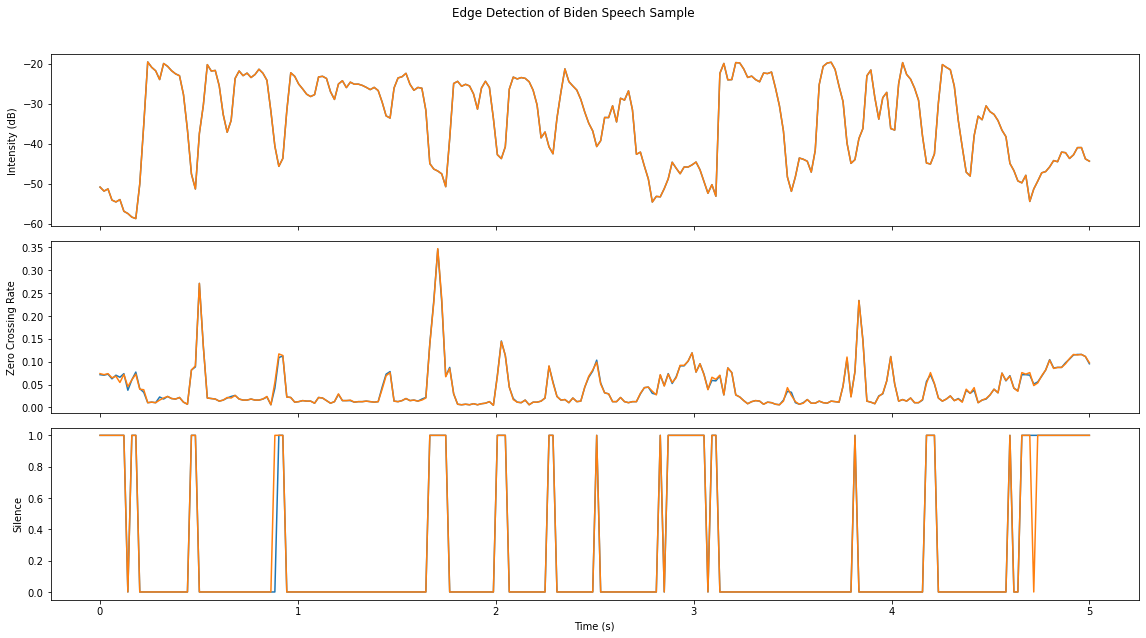

In [4]:
# Edge detection on a Biden speech sample
edge_detection(segments[0])

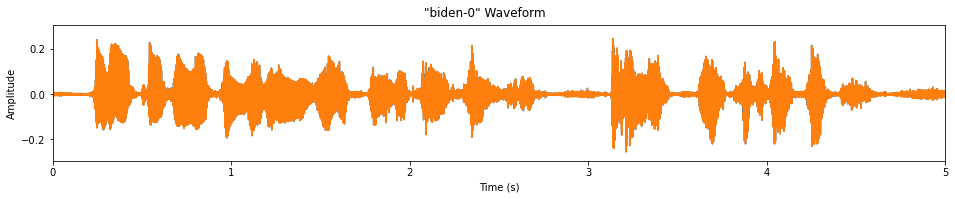

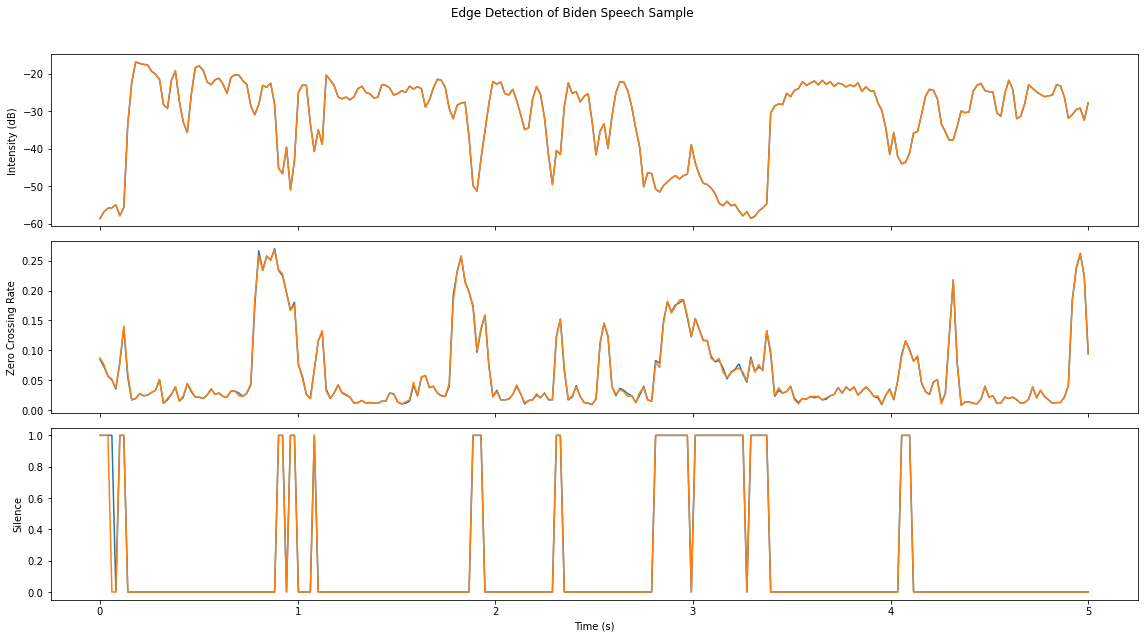

In [5]:
# Edge detection on a Trump speech sample
edge_detection(segments[37])

## Extracting Spectral Features

We can now analyze the spectral features of the audio. These provide insight into the frequencies present in the speech samples, allowing us to characterize different speakers based on their vocal patterns. In this section, we will compute various spectral statistics, amongst others, focusing on speech samples from Biden and Trump during the 2024 presidential debate.

Here we will collect:
- Speaker Name
- Segment ID
- Audio Sample Rate (FPS)
- Duration (sec)
- Sound Pressure Level (dB)
- Normalized Loudness (LUFS)
- Raw Loudness (LUFS)
- Centre of Gravity of Frequency Magnitudes
- Standard Deviation of Frequency Magnitudes
- Skewness of Frequency Magnitudes
- Kurtosis of Frequency Magnitudes
- Pitch

In [6]:
def clean(x):
    return np.round(x[0][0], 4)

metrics = []
for seg in segments:
    data = seg.get_signal_data()[:, 0]
    duration = seg.get_duration()
    fs = seg.get_sample_rate()
    id = seg.get_signal_id()
    
    # Extract frequencies in typical human F0 range
    _, mags, _ = asp.calc_spectra(signal=data, clip=True)
    freqs = wf.frequency_series(size=int(duration * fs), clip=True)
    peaks = asp.find_peaks(signal=mags, height=1)[0]
    mags, freqs = mags[peaks], freqs[peaks]
    mask = (freqs < 250) & (mags > 80)
    mags, freqs = mags[mask], freqs[mask]
    
    new_metrics = {
        # Waveform stats
        "speaker": id.split("-")[0],
        "id": id.split("-")[1],
        "sample_rate": fs,
        "duration": duration,
        
        # Sound stats
        "pressure": clean(asp.calc_spl(signal=data)),
        "norm_loudness": clean(asp.calc_loudness(signal=data, sample_rate=fs)),
        "raw_loudness": clean(asp.calc_loudness(signal=data, sample_rate=fs, scale=False)),
        
        # Spectral stats
        "centre_gravity": clean(asp.calc_centre_gravity(signal=data, sample_rate=fs)[0]),
        "std": clean(asp.calc_std(signal=data, sample_rate=fs)),
        "skew": clean(asp.calc_skewness(signal=data, sample_rate=fs)),
        "kurt": clean(asp.calc_kurtosis(signal=data, sample_rate=fs)),
        
        # Max frequency in typical human F0 range
        "pitch": freqs[np.argsort(mags, axis=0)[-1]]
    }
    
    metrics.append(new_metrics)
    
metrics = pd.DataFrame(metrics)
metrics.head()

,speaker,id,sample_rate,duration,pressure,norm_loudness,raw_loudness,centre_gravity,std,skew,kurt,pitch
0,biden,0,44100,112.853107,67.1740,-20.4521,-27.2575,403.1052,892.6321,6.2117,43.2249,153.394094
1,biden,1,44100,56.630862,67.2535,-20.3265,-27.0525,431.7009,937.9211,5.6909,37.3871,151.066040
2,biden,2,44100,62.648753,67.1415,-20.1544,-26.9923,465.3866,988.0759,5.3592,32.8206,152.740471
3,biden,3,44100,63.486757,67.0868,-20.3188,-27.2114,487.0463,987.0111,5.1562,30.1670,143.289725
4,biden,4,44100,34.229909,66.9133,-20.2128,-27.2789,514.3844,997.0438,4.9176,27.9499,154.747708


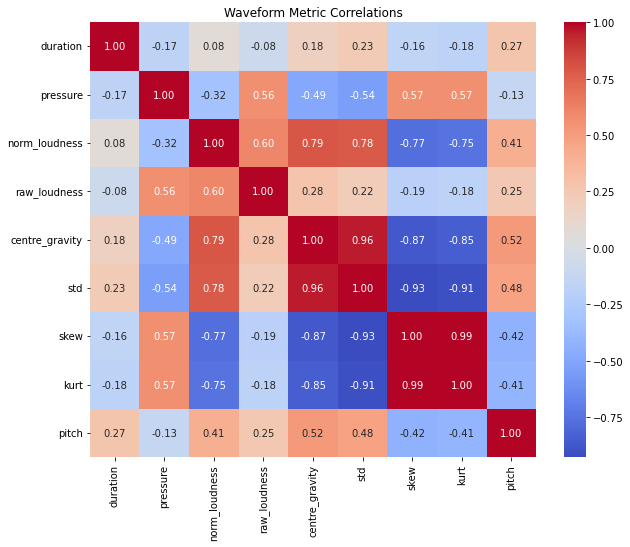

In [7]:
# Correlation plot between different metrics
# Note high positive correlations - CoG/STD, Skew/Kurt, NormLoud/CoG
# Note high negative correlations - Skew/CoG, NormLoud/Skew
# Some correlative strengths - Pressure, RawLoud, Pitch
# Little to no correlative strengths - Duration 

data = metrics.drop(columns=["sample_rate"])

corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Waveform Metric Correlations")
plt.show()

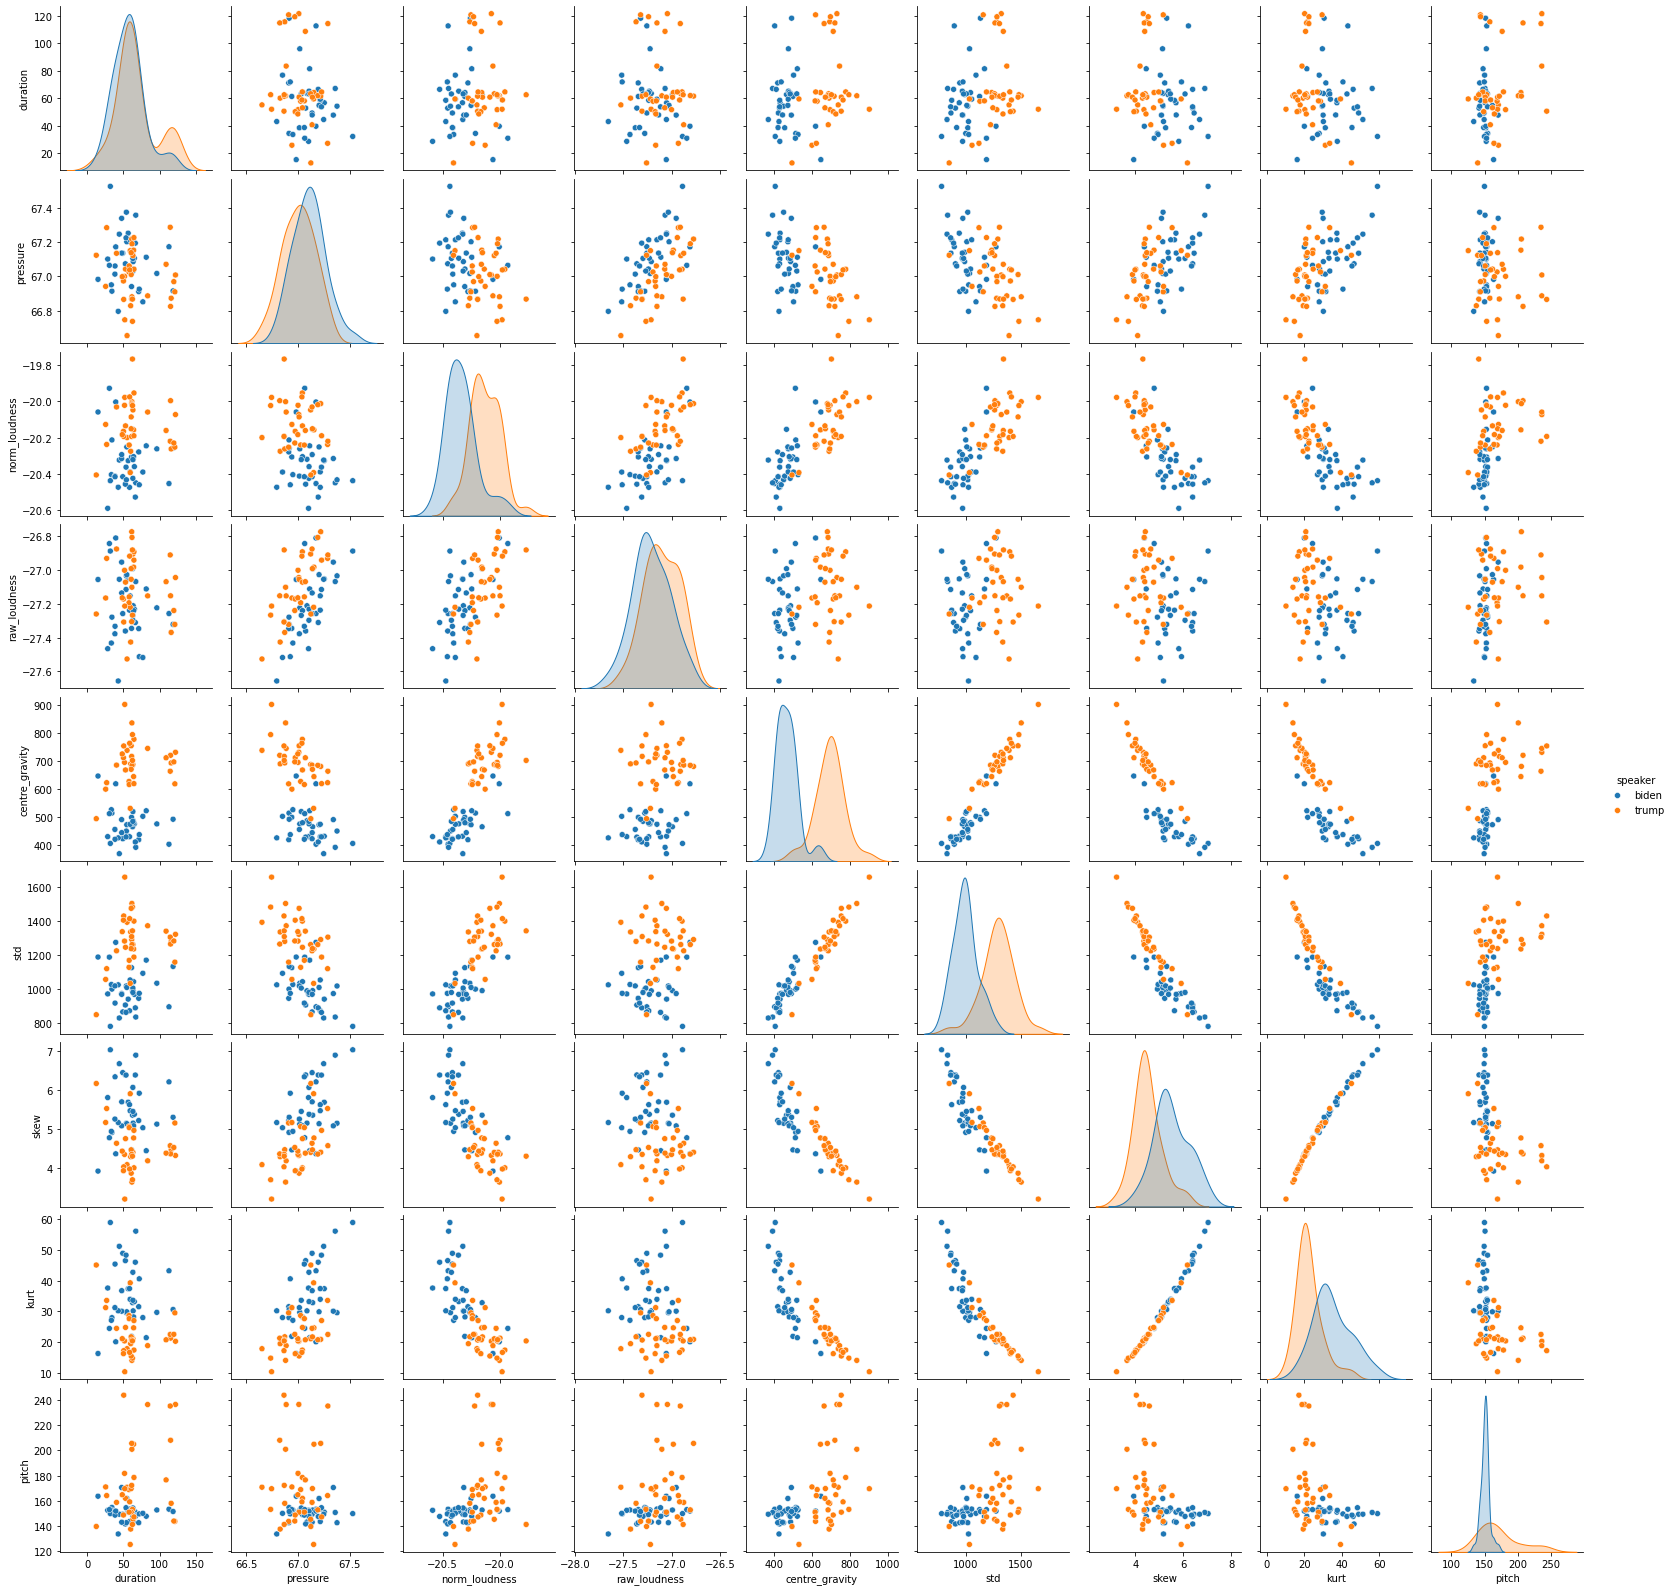

In [8]:
sns.pairplot(data, hue="speaker", diag_kind="kde")
plt.show()

## Building a Speaker Classification Model

Finally, we'll use the extracted spectral features to train a classification model that predicts which of the two speakers—Biden or Trump—is speaking in a given audio segment. This step will involve splitting the data into training and testing sets, training the model, and evaluating its performance.

Making a UMAP projection of the speaker data

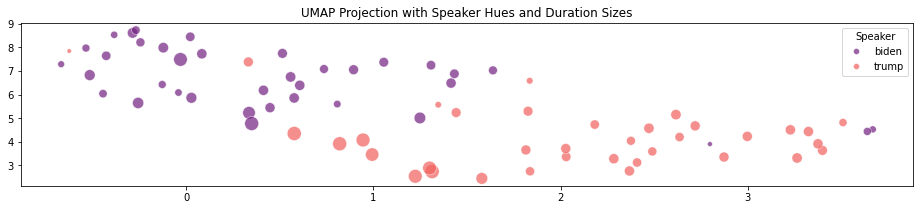

In [9]:
# Separate our metrics features from speaker class
X = data.drop(columns=["speaker", "id"])
y = data["speaker"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP Projection
umap_proj = umap.UMAP()
X_umap = umap_proj.fit_transform(X_scaled)

# Plot UMAP projection with hues for Biden and Trump
plt.figure(figsize=(16, 3))
scatter = sns.scatterplot(
    x=X_umap[:, 0], 
    y=X_umap[:, 1], 
    hue=y, 
    size=data["duration"],
    sizes=(20, 200),
    palette='magma',
    alpha=0.7,
    legend="brief"
)

# Remove the size legend (duration) from the plot
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles[1:3], labels=labels[1:3], title='Speaker')

plt.title('UMAP Projection with Speaker Hues and Duration Sizes')
plt.show()

Making a KMeans model on the speaker data (Unsupervised)

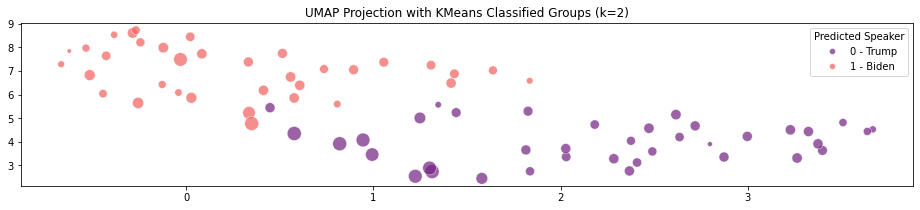

In [10]:
# Initialize and fit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Plot UMAP projection with KMeans classified groups
plt.figure(figsize=(16, 3))
scatter = sns.scatterplot(
    x=X_umap[:, 0], 
    y=X_umap[:, 1], 
    hue=cluster_labels, 
    size=data["duration"],
    sizes=(20, 200),
    palette='magma',
    alpha=0.7,
    legend="brief"
)

# Remove the size legend (duration) from the plot
handles, labels = scatter.get_legend_handles_labels()

# Map numeric labels to descriptive labels
label_mapping = {'0': '0 - Trump', '1': '1 - Biden'}
mapped_labels = [label_mapping[label] for label in labels[:2]]
scatter.legend(handles=handles[:2], labels=mapped_labels[:2], title='Predicted Speaker')

plt.title(f'UMAP Projection with KMeans Classified Groups (k=2)')
plt.show()

Performance evaluation of unsupervised learning model

Silhouette Score for k=2: 0.35
Adjusted Rand Index (ARI): 0.60
Precision: 0.87
Specificity: 0.86
Sensitivity: 0.92
F1 Score: 0.89


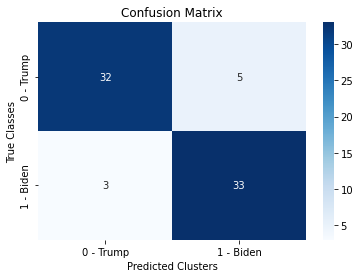

In [11]:
# Evaluate clustering performance using silhouette score
# Score of 0.35 suggest that the clustering structure is moderately defined.
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f'Silhouette Score for k=2: {sil_score:.2f}')

# Evaluate clustering performance using Adjusted Rand Index (ARI)
# Score of 0.6 suggest that the clustering structure is moderately/strongly defined.
ari = adjusted_rand_score(y, cluster_labels)
print(f'Adjusted Rand Index (ARI): {ari:.2f}')

# Evaluate clustering performance using Confusion Matrix
# Map true labels to 1 and 0 for 'biden' and 'trump'
str_cluster_labels = np.array([{1: "biden", 0: "trump"}[label] for label in cluster_labels])

# Generate confusion matrix
conf_matrix = confusion_matrix(y, str_cluster_labels)

# A function to calculate metrics from the confusion matrix
def calculate_metrics(conf_matrix):
    TN, FP, FN, TP = conf_matrix.ravel()

    # Sensitivity (Recall)
    sensitivity = TP / (TP + FN)
    
    # Specificity
    specificity = TN / (TN + FP)
    
    # Precision
    precision = TP / (TP + FP)
    
    # F1 Score
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return sensitivity, specificity, precision, f1

sensitivity, specificity, precision, f1 = calculate_metrics(conf_matrix)

print(f'Precision: {precision:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'F1 Score: {f1:.2f}')

# Define the labels for the axes
labels = ["0 - Trump", "1 - Biden"]

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.show()

Making a Logistic Regression model on Speaker data (Supervised))

In [12]:
# Map the true labels to 0 and 1
y_mapped = np.array([{'biden': 1, 'trump': 0}[label] for label in data['speaker']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply UMAP Projection (using the training set for fitting)
umap_proj = umap.UMAP()
X_train_umap = umap_proj.fit_transform(X_train_scaled)
X_test_umap = umap_proj.transform(X_test_scaled)

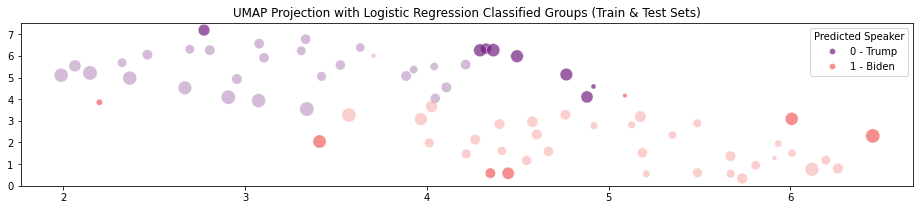

In [13]:
# Initialize and fit Logistic Regression on the training data
log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train_scaled, y_train)

# Predict the labels on both training and test data
train_labels = log_reg.predict(X_train_scaled)
test_labels = log_reg.predict(X_test_scaled)

# Plot UMAP projection with Logistic Regression classified groups for both train and test data
plt.figure(figsize=(16, 3))

# Plot training data with lower alpha
sns.scatterplot(
    x=X_train_umap[:, 0], 
    y=X_train_umap[:, 1], 
    hue=train_labels, 
    size=data.loc[X_train.index, "duration"],  # Use the 'duration' corresponding to the train set
    sizes=(20, 200),
    palette='magma',
    alpha=0.3,  # Lower alpha for training data
    legend=None  # Exclude legend for train data to avoid clutter
)

# Plot test data with higher alpha
sns.scatterplot(
    x=X_test_umap[:, 0], 
    y=X_test_umap[:, 1], 
    hue=test_labels, 
    size=data.loc[X_test.index, "duration"],  # Use the 'duration' corresponding to the test set
    sizes=(20, 200),
    palette='magma',
    alpha=0.7,  # Higher alpha for test data
    legend="brief"
)

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()

# Map numeric labels to descriptive labels
label_mapping = {'0': '0 - Trump', '1': '1 - Biden'}
mapped_labels = [label_mapping[label] for label in labels[:2]]

plt.legend(handles=handles[:2], labels=mapped_labels[:2], title='Predicted Speaker')

plt.title(f'UMAP Projection with Logistic Regression Classified Groups (Train & Test Sets)')
plt.show()

Performance evaluation of supervised learning model

Training Set Metrics:
Sensitivity (Recall): 0.97
Specificity: 0.93
Precision: 0.94
F1 Score: 0.95

Test Set Metrics:
Sensitivity (Recall): 1.00
Specificity: 0.89
Precision: 0.86
F1 Score: 0.92


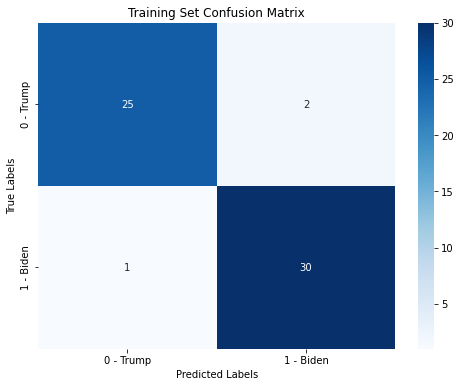

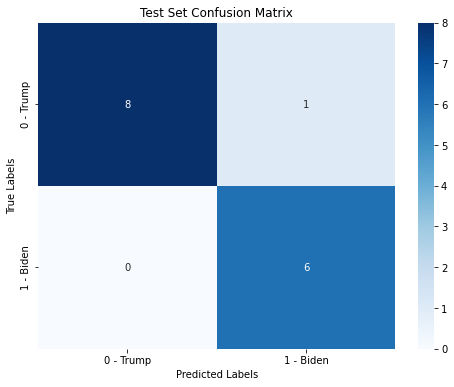

In [14]:
# Evaluate clustering performance using Confusion Matrix
# Map true labels to 1 and 0 for 'biden' and 'trump'
str_cluster_labels = np.array([{1: "biden", 0: "trump"}[label] for label in cluster_labels])

# Generate confusion matrix
train_conf_matrix = confusion_matrix(y_train, train_labels)
test_conf_matrix = confusion_matrix(y_test, test_labels)

# Calculate metrics for the training set
train_sensitivity, train_specificity, train_precision, train_f1 = calculate_metrics(train_conf_matrix)

# Calculate metrics for the test set
test_sensitivity, test_specificity, test_precision, test_f1 = calculate_metrics(test_conf_matrix)

# Print the results
print("Training Set Metrics:")
print(f"Sensitivity (Recall): {train_sensitivity:.2f}")
print(f"Specificity: {train_specificity:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"F1 Score: {train_f1:.2f}")

print("\nTest Set Metrics:")
print(f"Sensitivity (Recall): {test_sensitivity:.2f}")
print(f"Specificity: {test_specificity:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"F1 Score: {test_f1:.2f}")

# Step 7: Optionally, plot the confusion matrices
labels = ["0 - Trump", "1 - Biden"]

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Training Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [15]:
# Define the metrics for each evaluation
eval_data = {
    "Precision": [0.87, 0.94, 0.86],
    "Specificity": [0.86, 0.93, 0.89],
    "Sensitivity": [0.92, 0.97, 1.00],
    "F1 Score": [0.89, 0.95, 0.92]
}

# Define the row labels for each evaluation
index_labels = ["KMeans", "LogReg_Train", "LogReg_Test"]

# Create the DataFrame
eval_df = pd.DataFrame(eval_data, index=index_labels)

# Display the DataFrame
eval_df


,Precision,Specificity,Sensitivity,F1 Score
KMeans,0.87,0.86,0.92,0.89
LogReg_Train,0.94,0.93,0.97,0.95
LogReg_Test,0.86,0.89,1.00,0.92


- **KMeans Clustering (Unsupervised):**
  - KMeans showed strong performance in distinguishing between Biden and Trump without prior knowledge of labels, but with slightly lower accuracy compared to the supervised approach.

- **Logistic Regression (Supervised) - Training Set:**
  - The model effectively learned to distinguish between the two speakers, showing high accuracy and balanced performance across all metrics during training.

- **Logistic Regression (Supervised) - Test Set:**
  - The model maintained high performance on unseen data, with perfect sensitivity but a slight drop in precision, indicating some misclassification of Trump’s speech.

- **Overall Conclusion:**
  - **Supervised learning (Logistic Regression) outperformed unsupervised learning (KMeans)** in classifying Biden and Trump based on spectral speech metrics, especially in terms of sensitivity and generalization to new data.